# Traffic Sign Recognition with Tensorflow


This notebook is the first part of a tutorial to build a deep learning model for traffic sign recognition. The goal is to build a model that can detect and classify traffic signs in a video stream taken from a moving car. 


## First Objective: Traffic Sign Classification

I'll start with a simple goal: classifiction. Given an image of a traffic sign, our model should be able to tell it's type (e.g. Stop sign, speed limit, yield sign, ...etc.). We'll work with images that are properly cropped such that the traffic sign takes most of the image.


For this project, I'm using Pythong 3.5, Tensorflow 0.11, Numpy, Sci-kit Image, and Matplotlib. All pretty standard tools in machine learning. For convenience, I've created a docker image that contains the most common deep learning tools in one place here: https://hub.docker.com/r/waleedka/modern-deep-learning/ . You can run it with this command:

```
docker run -it -p 8888:8888 -p 6006:6006 -v ~/traffic:/traffic waleedka/modern-deep-learning
```

Note that I have the files of this project in the ~/traffic directory, and I'm it to /traffic directory in the Docker container. Modify this if you're using a different directory.

First step, let's import the needed libraries and get that out of the way.

In [1]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from numpy import array
# Allow image embeding in notebook
%matplotlib inline

## Trainging Dataset

We're using the Belgian Traffic Sign Dataset. Go to http://btsd.ethz.ch/shareddata/ and download the training and test data. There is a lot of datasets on that page, but you only need the two files listed under **BelgiumTS for Classification (cropped images)**":	
* BelgiumTSC_Training (171.3MBytes)
* BelgiumTSC_Testing (76.5MBytes)

After downloading and expanding the files, your directory structure should look something like this:

```
/traffic/datasets/BelgiumTS/Training/
/traffic/datasets/BelgiumTS/Testing/
```

Each of the two directories above has 62 sub-directories named sequentially from 00000 to 00062. The directory name represents the code (or label) and the images inside the directory are examples of that label. 

## Parse and Load the Training Data

The **Training** directory contains sub-directories with sequental numerical names from 00000 to 00061. The name of the directory represents the labels from 0 to 61, and the images in each directory represent the traffic signs that belong to that label. The images are saved in the not-so-common .ppm format, but luckily, this format is supported in the skimage library.

In [2]:
def load_train_data(data_directory):
    directories=[d for d in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory,d))]
    #d is every classification file
    labels=[]
    images=[]
    for d in directories:
        #每一类的路径
        label_directory=os.path.join(data_directory,d)
        file_names=[os.path.join(label_directory,f) for f in os.listdir(label_directory) if f.endswith(".png")]
        #定义标签 Red Circle=0；Green Circle=1；Red Left=2；Green Left=3；Red Up=4；Green Up=5；Red Right=6；Green Right=7 ；Red Negative=8；Green Negative=9
        if d == 'Red Circle':
            label=0
        elif d == 'Green Circle':
            label=1
        elif d == 'Red Left':
            label=2
        elif d == 'Green Left':
            label=3
        elif d == 'Red Up':
            label=4
        elif d == 'Green Up':
            label=5
        elif d == 'Red Right':
            label=6
        elif d == 'Green Right':
            label=7
        elif d == 'Red Negative':
            label=8
        else:
            label=9  
        #file_names is every photo which is end with ".png"
        for f in file_names:
            images.append(skimage.data.imread(f))   #read image
            labels.append(label)                   #read label
    return images,labels

def load_test_data(data_directory):
    images=[]
    file_names=[os.path.join(data_directory,f) for f in os.listdir(data_directory) if f.endswith(".png")]
    for f in file_names:
        images.append(skimage.data.imread(f))
    return images

#images and labels are list

ROOT_PATH=r"D:\study\2018autumn\ML\TL_Dataset"
train_data_directory=os.path.join(ROOT_PATH,"Training")
test_data_directory=os.path.join(ROOT_PATH,"Testing")
images,labels=load_train_data(train_data_directory)

Here we're loading two lists:
* **images** a list of images, each image is represted by a numpy array.
* **labels** a list of labels. Integers with values between 0 and 61.


It's not usually a good idea to load the whole dataset into memory, but this dataset is small and we're trying to keep the code simple, so it's okay for now. We'll improve it in the next part. For larger datasets, we'd want to have a separate thread loading chunks of data in the background and feeding them to the training thread. 

## Explore the Dataset

How many images and labels do we have?

In [3]:
print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))

Unique Labels: 10
Total Images: 26426


Display the first image of each label.

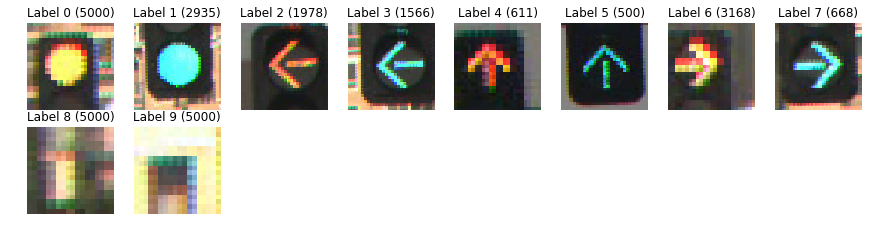

In [4]:
def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

display_images_and_labels(images, labels)

That looks great! The traffic signs occupy most of the area of each image, which is going to make our job easier: we don't have to look for the sign in the image. And we have a variety of angles and lighting conditions, which will help our model generalize. 

However, although the images are square-ish, they're not all the same size. They have different aspect ratios. Our simple neural network takes a fixed-size input, so we have a bit of pre-processing to do. We'll get to that soon, but first let's pick a label and see more of it's images. Let's pick label 7:

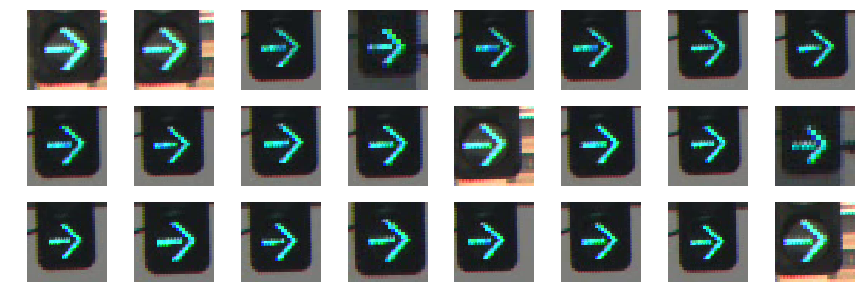

In [5]:
def display_label_images(images, label):
    """Display images of a specific label."""
    limit = 24  # show a max of 24 images
    plt.figure(figsize=(15, 5))
    i = 1

    start = labels.index(label)
    end = start + labels.count(label)
    for image in images[start:end][:limit]:
        plt.subplot(3, 8, i)  # 3 rows, 8 per row
        plt.axis('off')
        i += 1
        plt.imshow(image)
    plt.show()

display_label_images(images, 7)

Interesting! It looks like our dataset considers all speeding limit signs to be of the same class regardless of the numbers on them. That's fine, as long as we know about it beforehand and don't let it confuse us later when the output doesn't match our expectation. 

I'll leave exploring other labels as an exercise for you, edit the code above and check other labels. Make sure to check Labels 26 and 27. They also have numbers in a red circle, so our model will have to get really good to differentiate between these 3 classes.

## Handling images of different sizes?

Most neural networks expect a fixed-size input, and our network is no exception. But as we've seen above, our images are not all the same size. A common approach is to crop and pad the images to a selected apect ratio, but then we have to make sure that we don't cut-off parts of the traffic signs in the process. That seems like it might require manual work! Let's do a simpler solution instead (a hack really): We'll just resize the images to a fixed size and ignore the distortions caused by the different aspect ratios. A person can easily recognize a traffic sign even if it's compressed or stretched a bit, so we hope that our model can as well. 

And while we're at it, let's make the images smaller. The larger the input data, the larger the model, and the slower it is to train. In the early stages of development we want fast training to avoid long waits between iterations while we change the code rapidly. 

What are the sizes of our image anyway?

In [6]:
for image in images[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (56, 56, 3), min: 0, max: 255
shape: (56, 56, 3), min: 0, max: 255
shape: (52, 52, 3), min: 0, max: 255
shape: (63, 63, 3), min: 0, max: 255
shape: (63, 63, 3), min: 0, max: 255


The sizes seem to hover around 128x128. If we resize them to, say, 32x32, we'll have reduced the data and the model size by a factor of 16. And 32x32 is probably still big enough to recognize the signs, so let's go with that. 

I'm also in the habit of frequently printing the min() and max() values. It's a simple way to verify the range of your data and catch bugs early.

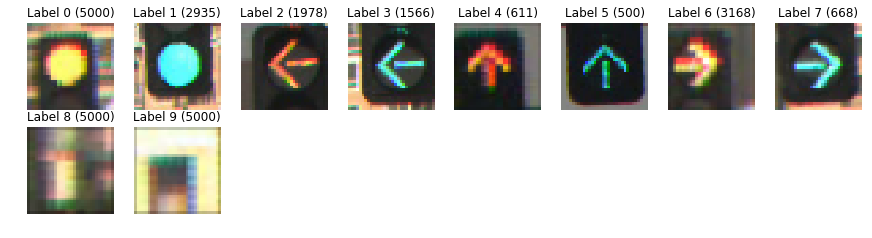

In [7]:
# Resize images
images32 = [skimage.transform.resize(image, (32, 32), mode='constant')
                for image in images]
display_images_and_labels(images32, labels)

The 32x32 images are not as sharp but still recognizable. Note that the display above shows the images larger than their real size because the matplotlib library tries to fit them to the grid size. Let's print the sizes of a few images to verify that we got it right.

In [8]:
for image in images32[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (32, 32, 3), min: 0.010294117647058752, max: 1.0
shape: (32, 32, 3), min: 0.01305147058823453, max: 1.0
shape: (32, 32, 3), min: 0.028783700980391392, max: 1.0
shape: (32, 32, 3), min: 0.0007094439338240134, max: 0.9999502144607844
shape: (32, 32, 3), min: 0.01618700214460812, max: 1.0


The sizes are correct. But check the min and max values! They now range from 0 to 1.0, which is different from the 0-255 range we saw above. The resizing function did that transformation for us. Normalizing values to the range 0.0-1.0 is very common so we'll keep it. But remember to multiply by 255 if you later want to convert the images back to the normal 0-255 range.

# Minimum Viable Model

In [9]:
labels_a = np.array(labels)
images_a = np.array(images32)
print("labels: ", labels_a.shape, "\nimages: ", images_a.shape)

labels:  (26426,) 
images:  (26426, 32, 32, 3)


In [10]:
# Create a graph to hold the model.
graph = tf.Graph()

# Create model in the graph.
with graph.as_default():
    # Placeholders for inputs and labels.
    images_ph = tf.placeholder(tf.float32, [None, 32, 32, 3])
    labels_ph = tf.placeholder(tf.int32, [None])

    # Flatten input from: [None, height, width, channels]
    # To: [None, height * width * channels] == [None, 3072]
    images_flat = tf.contrib.layers.flatten(images_ph)

    # Fully connected layer. 
    # Generates logits of size [None, 10]
    logits = tf.contrib.layers.fully_connected(images_flat, 10, tf.nn.relu)

    # Convert logits to label indexes (int).
    # Shape [None], which is a 1D vector of length == batch_size.
    predicted_labels = tf.argmax(logits, 1)

    # Define the loss function. 
    # Cross-entropy is a good choice for classification.
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels_ph))

    # Create training op.
    train = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

    # And, finally, an initialization op to execute before training.
    init = tf.global_variables_initializer()

print("images_flat: ", images_flat)
print("logits: ", logits)
print("loss: ", loss)
print("predicted_labels: ", predicted_labels)

images_flat:  Tensor("Flatten/Reshape:0", shape=(?, 3072), dtype=float32)
logits:  Tensor("fully_connected/Relu:0", shape=(?, 10), dtype=float32)
loss:  Tensor("Mean:0", shape=(), dtype=float32)
predicted_labels:  Tensor("ArgMax:0", shape=(?,), dtype=int64)


## Training

In [11]:
# Create a session to run the graph we created.
session = tf.Session(graph=graph)

# First step is always to initialize all variables. 
# We don't care about the return value, though. It's None.
_ = session.run([init])

In [12]:
for i in range(201):
    _, loss_value = session.run([train, loss], 
                                feed_dict={images_ph: images_a, labels_ph: labels_a})
    if i % 10 == 0:
        print("Loss: ", loss_value)

Loss:  2.3376
Loss:  1.2048
Loss:  0.952532
Loss:  0.848583
Loss:  0.789861
Loss:  0.751153
Loss:  0.722289
Loss:  0.699668
Loss:  0.681486
Loss:  0.666499
Loss:  0.653939
Loss:  0.643262
Loss:  0.634049
Loss:  0.626003
Loss:  0.618897
Loss:  0.612572
Loss:  0.606903
Loss:  0.601789
Loss:  0.597151
Loss:  0.592922
Loss:  0.589044


## Using the Model

The session object contains the values of all the variables in our model (i.e. the weights). 

In [13]:
# Pick 10 random images
sample_indexes = random.sample(range(len(images32)), 10)
sample_images = [images32[i] for i in sample_indexes]
sample_labels = [labels[i] for i in sample_indexes]

# Run the "predicted_labels" op.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: sample_images})[0]
print(sample_labels)
print(predicted)

[1, 0, 1, 0, 0, 3, 8, 2, 1, 9]
[1 0 1 0 0 1 9 0 1 9]


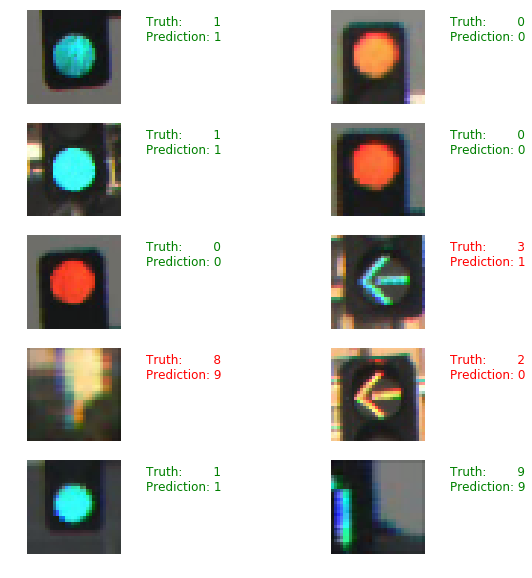

In [14]:
# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted[i]
    plt.subplot(5, 2,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
             fontsize=12, color=color)
    plt.imshow(sample_images[i])


## Evaluation

It's fun to visualize the results, but we need a more precise way to measure the accuracy of our model. Also, it's important to test it on images that it hasn't seen. And that's where the validation data set comes into play.

In [15]:
# Load the test dataset.
test_images = load_test_data(test_data_directory)

In [16]:
# Transform the images, just like we did with the training set.
test_images32 = [skimage.transform.resize(image, (32, 32), mode='constant')
                 for image in test_images]

In [17]:
# Run predictions against the full test set.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: test_images32})[0]

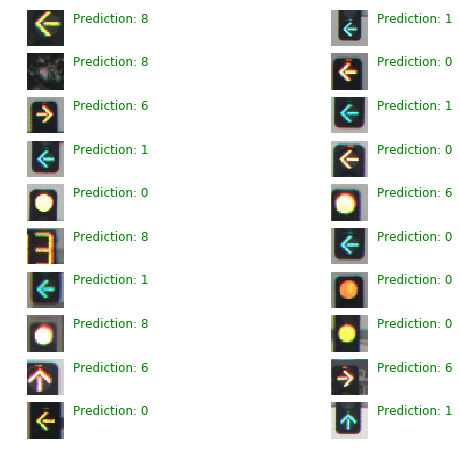

In [18]:
# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(10, 40))

test0_indexes = random.sample(range(len(test_images)), 20)
test0_images = [test_images[i] for i in test0_indexes]

for i in range(len(test0_images)):
    prediction = predicted[i]
    plt.subplot(50, 2,1+i)
    plt.axis('off')
    plt.text(40, 10, "Prediction: {0}".format(prediction), 
             fontsize=12, color=color)
    plt.imshow(test_images32[i])

In [19]:
# Close the session. This will destroy the trained model.
session.close()